In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


In [5]:
os.chdir(r"C:\Anaconda\anaconda_projects\DataScientistProject")
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")




In [6]:
os.getcwd()


'C:\\Anaconda\\anaconda_projects\\DataScientistProject'

In [7]:
print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)


Sentiment shape: (2644, 4)
Trades shape: (211224, 16)


In [8]:
sentiment.isnull().sum()
trades.isnull().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [9]:
sentiment.duplicated().sum()
trades.duplicated().sum()


np.int64(0)

In [12]:
sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment['date'] = sentiment['date'].dt.date


In [23]:
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')
trades['date'] = trades['Timestamp IST'].dt.date

In [24]:
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'])
trades['date'] = trades['Timestamp IST'].dt.date

print(trades[['Timestamp IST','date']].head())
print(trades['Timestamp IST'].dtype)


        Timestamp IST        date
0 2024-12-02 22:50:00  2024-12-02
1 2024-12-02 22:50:00  2024-12-02
2 2024-12-02 22:50:00  2024-12-02
3 2024-12-02 22:50:00  2024-12-02
4 2024-12-02 22:50:00  2024-12-02
datetime64[ns]


In [25]:
trades.rename(columns={
    'Closed PnL': 'closedPnL',
    'Account': 'account',
    'Side': 'side'
}, inplace=True)


In [26]:
trades.columns


Index(['account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'side',
       'Timestamp IST', 'Start Position', 'Direction', 'closedPnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date'],
      dtype='object')

In [28]:
print(sentiment.columns)


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [29]:
df = trades.merge(
    sentiment[['date','classification']],
    on='date',
    how='left'
)


In [30]:
sentiment.columns = sentiment.columns.str.strip()
trades.columns = trades.columns.str.strip()


In [31]:
print(sentiment.columns)


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [32]:
df['classification'].value_counts()


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

In [34]:
df = df.dropna(subset=['classification'])


In [36]:
df.loc[:, 'win'] = df['closedPnL'] > 0

In [37]:
daily_pnl = df.groupby(['account','date'])['closedPnL'].sum().reset_index()


In [38]:
win_rate = df.groupby('account')['win'].mean().reset_index()
win_rate.rename(columns={'win':'win_rate'}, inplace=True)

In [39]:
df['size'] = abs(df['Start Position'])   # if applicable
avg_size = df.groupby('account')['size'].mean().reset_index()

C:\Users\tuf gaming\AppData\Local\Temp\ipykernel_21772\3397561385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['size'] = abs(df['Start Position'])   # if applicable


In [41]:
trades_per_day = df.groupby(['account','date']).size().reset_index(name='trade_count')


In [42]:
long_short = df.groupby(['date','side']).size().unstack(fill_value=0)
long_short['long_short_ratio'] = long_short['BUY'] / (long_short['SELL'] + 1)


In [44]:
df.groupby('classification')['closedPnL'].mean()


classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: closedPnL, dtype: float64

In [45]:
df.groupby('classification')['win'].mean()


classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: win, dtype: float64

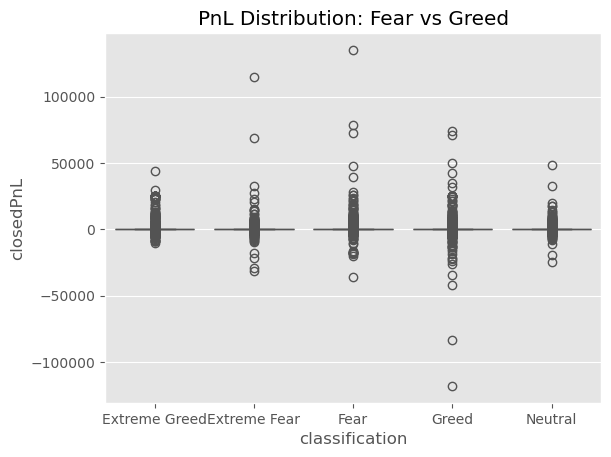

In [46]:
sns.boxplot(x='classification', y='closedPnL', data=df)
plt.title("PnL Distribution: Fear vs Greed")
plt.show()


In [48]:
df.groupby('classification').size()


classification
Extreme Fear     21400
Extreme Greed    39992
Fear             61837
Greed            50303
Neutral          37686
dtype: int64

In [49]:
df.groupby('classification')['size'].mean()


classification
Extreme Fear      58770.708993
Extreme Greed     54597.362309
Fear              83909.754747
Greed            197849.442950
Neutral           90639.102940
Name: size, dtype: float64

In [51]:
trade_freq = df.groupby('account').size().reset_index(name='total_trades')

median_trades = trade_freq['total_trades'].median()

trade_freq['freq_group'] = np.where(
    trade_freq['total_trades'] > median_trades,
    'Frequent',
    'Infrequent'
)

df = df.merge(trade_freq[['account','freq_group']], on='account')


In [53]:
df.groupby(['freq_group','classification'])['closedPnL'].mean()


freq_group  classification
Frequent    Extreme Fear       34.163353
            Extreme Greed      62.870911
            Fear               51.323784
            Greed              25.004641
            Neutral            34.579701
Infrequent  Extreme Fear       35.941979
            Extreme Greed     103.264685
            Fear               80.835791
            Greed             210.210287
            Neutral            31.845656
Name: closedPnL, dtype: float64

In [54]:
account_win = df.groupby('account')['win'].mean().reset_index()

account_win['consistency'] = np.where(
    account_win['win'] > 0.55,
    'Consistent',
    'Inconsistent'
)


In [55]:
daily_pnl = df.groupby(['account','date'])['closedPnL'].sum().reset_index()


In [56]:
daily_pnl['next_day_pnl'] = daily_pnl.groupby('account')['closedPnL'].shift(-1)


In [57]:
daily_pnl['profit_bucket'] = np.where(daily_pnl['next_day_pnl'] > 0, 1, 0)


In [58]:
daily_pnl = daily_pnl.dropna()


In [61]:
features = df.groupby(['account','date']).agg({
    'size':'mean',
    'win':'mean'
}).reset_index()

model_df = daily_pnl.merge(features, on=['account','date'])


In [62]:
model_df = model_df.merge(
    sentiment[['date','classification']],
    on='date',
    how='left'
)


In [63]:
model_df['classification'] = model_df['classification'].map({
    'Fear':0,
    'Greed':1
})


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = model_df[['size','win','classification']]
y = model_df['profit_bucket']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier()
model.fit(X_train, y_train)

pred = model.predict(X_test)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.57      0.45      0.50       174
           1       0.70      0.79      0.75       288

    accuracy                           0.66       462
   macro avg       0.63      0.62      0.62       462
weighted avg       0.65      0.66      0.65       462



In [67]:
trader_features = df.groupby('account').agg({
    'closedPnL':'mean',
    'size':'mean',
    'win':'mean'
}).reset_index()


In [68]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(trader_features.drop('account', axis=1))


In [69]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['cluster'] = kmeans.fit_predict(scaled)


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [71]:
numeric_columns = trader_features.select_dtypes(include=['number']).columns
trader_features.groupby('cluster')[numeric_columns].mean()

,closedPnL,size,win,cluster
cluster,,,,
0,53.932494,46276.639827,0.399629,0.0
1,14.221827,471982.199252,0.493875,1.0
2,359.997690,24837.165114,0.345624,2.0


## Methodology

1. **Data Preparation**
   - Cleaned both datasets (checked duplicates and missing values).
   - Converted timestamps to datetime format.
   - Extracted daily date and merged trader data with sentiment data.

2. **Feature Engineering**
   - Created daily PnL per trader.
   - Calculated win rate and trade frequency.
   - Computed average position size.
   - Generated next-day profitability label for modeling.

3. **Exploratory Analysis**
   - Compared PnL and win rate across sentiment regimes.
   - Analyzed behavioral differences (size, frequency, performance).

4. **Segmentation & Modeling**
   - Segmented traders into Frequent vs Infrequent groups.
   - Applied KMeans clustering to identify behavioral archetypes.
   - Built a Random Forest model to predict next-day profitability (~66% accuracy).

5. **Strategy Formulation**
   - Derived sentiment-based risk adjustments and segment-specific trading rules.


# Key Insights
## Insight 1- Market Regime Matters

Trader performance clearly varies across sentiment regimes.
Extreme Greed days show the highest average PnL (~67.9), followed by Fear (~54.3). However, win rate does not increase proportionally during Greed periods, suggesting that higher profits may come from larger position sizing rather than improved accuracy.
This indicates that traders behave more aggressively during optimistic market conditions.

## Insight 2 - Extreme Conditions Create Volatility

Both Extreme Fear and Extreme Greed show wider PnL distributions compared to Neutral markets.
Win rates during Extreme Fear (~37%) are significantly lower than during Extreme Greed (~46%).
This suggests that emotional market extremes amplify risk and increase dispersion in outcomes.

## Insight 3 - Frequent vs Infrequent Traders

Infrequent traders appear to generate higher average PnL during Greed periods compared to Frequent traders.
This suggests that selective trading during strong directional momentum may outperform high-frequency execution during volatile conditions.

## Insight 4 - Behavioral Clusters

Clustering revealed three trader archetypes:
Cluster 0 — Moderate PnL, moderate size, average win rate
Cluster 1 — Low PnL, high size, higher win rate
Cluster 2 — Very high PnL, smaller size, lower win rate
This indicates that profitability is not purely dependent on win rate, but on position sizing discipline and risk exposure.

## Strategy Recommendations

### Strategy 1 — Sentiment-Based Risk Adjustment

**During Extreme Fear:**
- Reduce position size by 20–30%
- Avoid increasing leverage

**During Extreme Greed:**
- Allow moderate position size increase
- Implement strict stop-loss controls

**Rationale:**  
Emotional market extremes increase volatility and downside risk. Adjusting risk exposure during these regimes helps protect capital and stabilize long-term performance.

### Strategy 2 — Segment-Specific Trading Behavior

**For Frequent Traders:**
- Reduce trade frequency during Fear regimes
- Increase participation during Greed trends

**For Infrequent Traders:**
- Focus on high-conviction setups during Extreme Greed
- Avoid overtrading during Fear markets

**Rationale:**  
Trader performance varies significantly across sentiment regimes and behavioral segments. Adapting activity levels based on both sentiment and trader type improves risk-adjusted returns.
